In [ ]:
!pip install catboost
!pip install natasha
!pip install transformers

In [2]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer

import pandas as pd 
import numpy as np
import re
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from natasha import (Segmenter, MorphVocab,  NewsEmbedding, NewsMorphTagger, Doc)
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
nltk.download('wordnet')


import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
russian_stopwords = stopwords.words("russian")

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_data = pd.read_json(path_or_buf=r"/content/drive/MyDrive/Colab Notebooks/train.jsonl", lines=True)
val_data = pd.read_json(path_or_buf=r"/content/drive/MyDrive/Colab Notebooks/val.jsonl", lines=True)
test_data = pd.read_json(path_or_buf=r"/content/drive/MyDrive/Colab Notebooks/test.jsonl", lines=True)

In [7]:
train_data["label"] = train_data["label"].apply(lambda x: 1 if x == "entailment" else 0)
val_data["label"] = val_data["label"].apply(lambda x: 1 if x == "entailment" else 0)

In [8]:
morph_vocab = MorphVocab()
segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

# Preprocessing

In [9]:
def get_lemmas(text):
  text = Doc(text)
  text.segment(segmenter) 
  text.tag_morph(morph_tagger)
  for token in text.tokens:
    token.lemmatize(morph_vocab)
  return " ".join([token.lemma for token in text.tokens if token.lemma not in russian_stopwords])

def get_rid_punctuation(text):
  text = text.translate(str.maketrans("", "", punctuation))
  text = re.sub(r'[0-9]+', "digit", text.lower())
  return text.lower()

In [10]:
train_data["premise"] = train_data["premise"].apply(lambda t: get_rid_punctuation(t))
train_data["hypothesis"] = train_data["hypothesis"].apply(lambda t: get_rid_punctuation(t))

# New type of dataset

In [13]:
max_len = 128

In [11]:
from transformers import BertTokenizer

In [52]:
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

In [14]:
class BertDataset:
    def __init__(self, q1, q2, target=[]):
        self.q1 = q1
        self.q2 = q2
        self.target = target 
        
    def __getitem__(self, item):
        q1 = " ".join(str(self.q1[item]).split())
        q2 = " ".join(str(self.q2[item]).split())

        inputs = tokenizer([q1, q2], add_special_tokens=True, pad_to_max_length=True, truncation=True, max_length=max_len, return_tensors='pt')

        return { 
            "inputs": torch.tensor(inputs["input_ids"], dtype=torch.long), 
            "mask": torch.tensor(inputs["attention_mask"], dtype=torch.long),
            "token_type_ids": torch.tensor(inputs["token_type_ids"], dtype=torch.long), 
            "labels": torch.tensor(int(self.target[item]), dtype=torch.long)
        }

    def __len__(self):
        return len(self.target)

In [15]:
dataset_train = BertDataset(train_data["premise"], train_data["hypothesis"], train_data["label"])
dataset_val = BertDataset(val_data["premise"], val_data["hypothesis"], val_data["label"])

In [16]:
train_loader = DataLoader(dataset_train, drop_last=True , batch_size=16)
val_loader = DataLoader(dataset_val, drop_last=True, batch_size=16)

In [17]:
batch = next(iter(train_loader))

## bert model 2

In [18]:
from transformers import AutoModel

model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased", output_hidden_states = True)

In [ ]:
from torch.nn import BCELoss
from torch.nn.functional import cosine_similarity
from torch.nn import ReLU

In [ ]:
class EntailmentClassifier(nn.Module):
    def __init__(self, model, metric, softmax):
        super().__init__()

        self.model = model
        self.metric = cosine_similarity
        self.softmax = softmax

    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

    def forward(self, inputs, mask, token_type_ids):
        sent_1 = model(inputs[:, 0, :], attention_mask=mask[:,0, :], token_type_ids=token_type_ids[:,0, :])
        sent_2 = model(inputs[:, 1, :], attention_mask=mask[:, 1, :], token_type_ids=token_type_ids[:, 1, :])
        
        sent_1_emb = self.mean_pooling(sent_1, mask[:,0, :])
        sent_2_emb = self.mean_pooling(sent_2, mask[:, 1, :])

        proba = self.softmax(self.metric(sent_1_emb, sent_2_emb))
        return proba

In [ ]:
inputs = batch["inputs"].squeeze(1).to(device)
attention_mask = batch["mask"].squeeze(1).to(device)
token_type_ids = batch["token_type_ids"].squeeze(1).to(device)
labels = batch["labels"].to(torch.float32).to(device)

In [ ]:
predicted = clf(inputs, attention_mask, token_type_ids)

In [ ]:
score = accuracy_score(predicted.cpu().detach().numpy(), labels.cpu())

In [ ]:
loss = BCELoss()
soft = ReLU()
clf = EntailmentClassifier(model, cosine_similarity, soft).to(device)
optimizer = torch.optim.Adam(clf.parameters(), lr=2e-5)
criterion = nn.BCELoss()
metric = accuracy_score

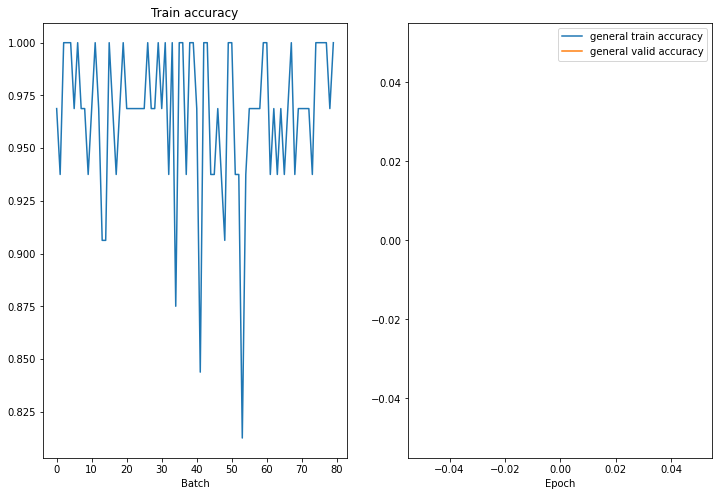

Epoch: 10 | Time: 2m 0s
	Train Loss: 0.808 | Train PPL:   2.243
	 Val. Loss: 5.577 |  Val. PPL: 264.285


In [ ]:
train_history = []
valid_history = []
train_history_metric, valid_history_metric = [], []

N_EPOCHS = 3
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_metric = train(clf, train_loader, optimizer, criterion, CLIP, metric, train_history, valid_history, train_history_metric, valid_history_metric)
    valid_loss = evaluate(clf, val_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(clf.state_dict(), 'best-val-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
true_labels, pred_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        inputs = batch["inputs"].squeeze(1).to(device)
        attention_mask = batch["mask"].squeeze(1).to(device)
        token_type_ids = batch["token_type_ids"].squeeze(1).to(device)
        labels = batch["labels"].to(torch.float32).to(device)
        
        output = clf(inputs, attention_mask, token_type_ids)

        output = torch.where(output > 0.5, 1, 0)
        true_labels.append(labels.cpu().numpy())
        pred_labels.append(output.cpu().numpy())
true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)

In [ ]:
def train(model, iterator, optimizer, criterion, clip, metric, train_history=None, valid_history=None, train_history_metric=None, valid_history_metric=None):
    model.train()
    
    epoch_loss, epoch_accuracy = 0, 0
    history, metric_history = [], []
    for i, batch in enumerate(iterator):
        
        inputs = batch["inputs"].squeeze(1).to(device)
        attention_mask = batch["mask"].squeeze(1).to(device)
        token_type_ids = batch["token_type_ids"].squeeze(1).to(device)
        labels = batch["labels"].to(torch.float32).to(device)
        
        optimizer.zero_grad()
        
        output = model(inputs, attention_mask, token_type_ids)

        loss = criterion(output, labels) 
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()

        predicted = np.array([1 if i > 0.5 else 0 for i in output])
        metric_result = metric(predicted, labels.cpu().numpy())

        history.append(loss.cpu().data.numpy())
        metric_history.append(metric_result)
        epoch_accuracy += metric_result.item()

        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()
        if (i+1) % 20 == 0:
          fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

          clear_output(True)
          ax[0].plot(metric_history, label='train f1')
          ax[0].set_xlabel('Batch')
          ax[0].set_title('Train accuracy')
          if train_history_metric is not None:
              ax[1].plot(train_history_metric, label='general train accuracy')
              ax[1].set_xlabel('Epoch')
          if valid_history_metric is not None:
              ax[1].plot(valid_history_metric, label='general valid accuracy')
          plt.legend()
          plt.show()
          
        
    return epoch_loss / (i + 1), epoch_accuracy / (i + 1)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            inputs = batch["inputs"].squeeze(1).to(device)
            attention_mask = batch["mask"].squeeze(1).to(device)
            token_type_ids = batch["token_type_ids"].squeeze(1).to(device)
            labels = batch["labels"].to(torch.float32).to(device)
            
            output = model(inputs, attention_mask, token_type_ids)

            loss = criterion(output, labels)
            
            epoch_loss += loss.item()
        
    return epoch_loss / (i + 1)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# solution with embeds from word2vec 

In [59]:
from navec import Navec

In [61]:
path = '/content/navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path)

In [71]:
def get_embd(sent_1, sent_2):
  sent_1 = np.array([navec.get(word) for word in sent_1.split()])
  sent_2 = np.array([navec.get(word) for word in sent_2.split()])

  sent_1 = np.mean(sent_1, axis=0)
  sent_2 = np.mean(sent_2, axis=0)
  return np.hstack([sent_1, sent_2])

In [97]:
sentence_1 = np.mean(s_1, axis=0)
sentence_2 = np.mean(s_2, axis=0)

In [102]:
train_data['mean_embedding'] = train_data.apply(lambda x: get_embd(x['premise'], x['hypothesis']), axis=1)

In [120]:
train_ = train_data["mean_embedding"].to_list()

In [98]:
result = 1 - spatial.distance.cosine(sentence_1, sentence_2)